# Egg adaptation of Perth/2009 HA
Juhye Lee produced deep mutational scanning libraries of the HA of A/Perth/2009 (H3N2).
These are library transfection supernatants.
Juhye passaged some of the library supernatants in MDCK-SIAT1-TMPRSS2 cells.
Theresa Eilola in Scott Hensley's lab passaged these libraries in eggs and pooled several eggs for each library.
Rachel Eguia performed barcoded subamplicon sequencing of the cell- and egg-passaged libraries.

## Import Python modules

In [1]:
import os
import subprocess

import pandas as pd

import dms_tools2
from dms_tools2.ipython_utils import showPDF
print(f"Using dms_tools2 version {dms_tools2.__version__}")

Using dms_tools2 version 2.5.dev1


Number of CPUs to use:

In [2]:
ncpus = 4

## Define samples
To be consistent with the nomenclature in [Lee et al (2019)](https://www.biorxiv.org/content/10.1101/670497v1), we rename as follows:

 - L4 here is lib1 in Lee et al.
 - L5 here is lib2 in Lee et al.
 - L6 here is lib3 in Lee et al.
 
We have each library passaged in cells, and in eggs.
We also have a control sequencing of wildtype plasmid to estimate the error rate.
Each egg sample is actually the pool of several eggs infected with that library:

In [3]:
fastqpath = ('/fh/fast/bloom_j/SR/ngs/illumina/reguia/'
             '190725_D00300_0788_AH3JCJBCX3_lane1/Unaligned/Project_reguia')

samples = pd.DataFrame.from_records(
        [('lib1-cell', os.path.join(fastqpath, 'Sample_L4mock/*_R1_*.fastq.gz')),
         ('lib1-egg', os.path.join(fastqpath, 'Sample_L4pooledegg/*_R1_*.fastq.gz')),
         ('lib2-cell', os.path.join(fastqpath, 'Sample_L5mock/*_R1_*.fastq.gz')),
         ('lib2-egg', os.path.join(fastqpath, 'Sample_L5pooledegg/*_R1_*.fastq.gz')),
         ('lib3-cell', os.path.join(fastqpath, 'Sample_L6mock/*_R1_*.fastq.gz')),
         ('lib3-egg', os.path.join(fastqpath, 'Sample_L6pooledegg/*_R1_*.fastq.gz')),
         ('wt', os.path.join(fastqpath, 'Sample_WTplasmid/*_R1_*.fastq.gz')),
         ],
        columns=['name', 'R1']
        )

samples

,name,R1
0,lib1-cell,/fh/fast/bloom_j/SR/ngs/illumina/reguia/190725...
1,lib1-egg,/fh/fast/bloom_j/SR/ngs/illumina/reguia/190725...
2,lib2-cell,/fh/fast/bloom_j/SR/ngs/illumina/reguia/190725...
3,lib2-egg,/fh/fast/bloom_j/SR/ngs/illumina/reguia/190725...
4,lib3-cell,/fh/fast/bloom_j/SR/ngs/illumina/reguia/190725...
5,lib3-egg,/fh/fast/bloom_j/SR/ngs/illumina/reguia/190725...
6,wt,/fh/fast/bloom_j/SR/ngs/illumina/reguia/190725...


## Align deep sequencing and count mutations
We do this using `dms2_batch_bcsubamp` since we did barcoded subamplicon sequencing:

In [4]:
# Reference coding sequence of Perth/2009 HA
refseq = './data/Perth09_HA_reference.fa'

# Temporary align specs
alignspecs = ['1,285,38,40', '286,567,33,34', '568,852,34,30', 
              '853,1137,34,31', '1138,1422,36,29', '1423,1701,39,44']

countsdir = './results/codoncounts/'
os.makedirs(countsdir, exist_ok=True)

# write sample information to a batch file for dms2_batch_bcsubamplicons
countsbatchfile = os.path.join(countsdir, 'batch.csv')
samples.to_csv(countsbatchfile, index=False)

print('\nNow running dms2_batch_bcsubamp...')
out = subprocess.check_output([
        'dms2_batch_bcsubamp',
        '--batchfile', countsbatchfile,
        '--refseq', refseq,
        '--alignspecs', *alignspecs,
        '--outdir', countsdir,
        '--summaryprefix', 'summary',
        '--R1trim', '200', '--R2trim', '165',
        '--ncpus', str(ncpus),
        '--use_existing', 'yes',
        ])

print('Completed dms2_batch_bcsubamp.')

samples['countsfile'] = countsdir + samples['name'] + '_codoncounts.csv'
assert all(map(os.path.isfile, samples['countsfile'])), 'did not find all codon counts files'


Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


Look at created files, all of which will have the following prefix:

In [5]:
countsplotprefix = os.path.join(countsdir, 'summary')

Stats on number of reads and barcodes.
All of these are good and similar among samples:

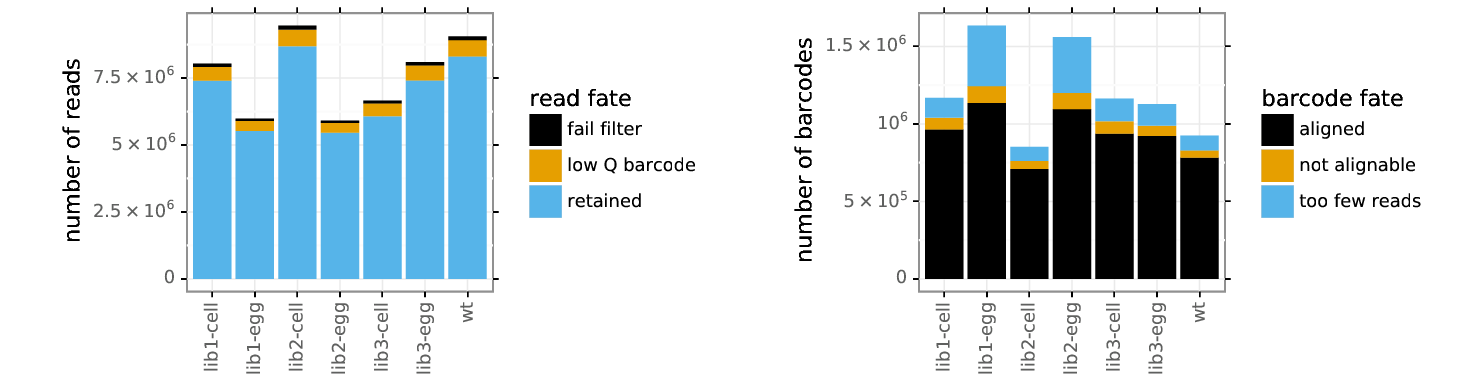

In [6]:
showPDF([countsplotprefix + '_readstats.pdf',
         countsplotprefix + '_bcstats.pdf'])

Reads per barcode: samples are adequately sequenced, and often sequenced more than needed:

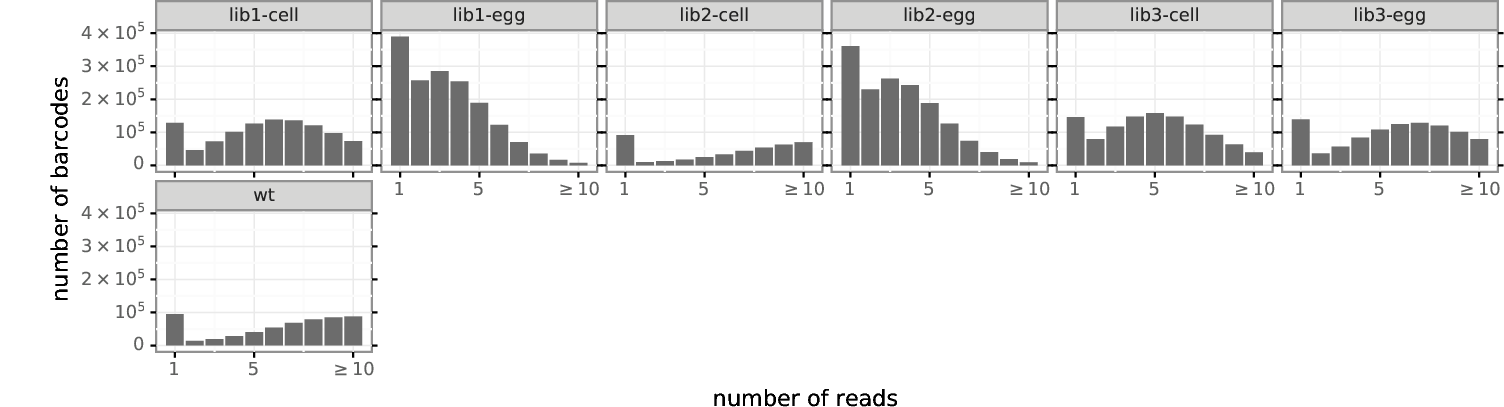

In [7]:
showPDF(countsplotprefix + '_readsperbc.pdf')

Sequencing depth across gene.
The depth is good for all samples, $>10^5$ per site in all cases:

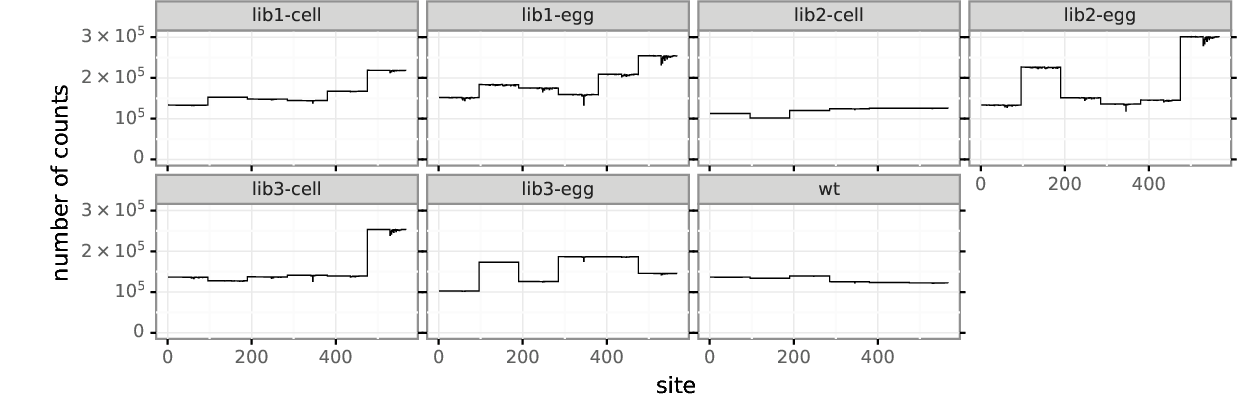

In [8]:
showPDF(countsplotprefix + '_depth.pdf')

Mutation rate across gene: we see that at most sites there is stronger purifying selection in the egg than in the cells. 
This makes sense, as the egg virus is really the cell virus passaged a second time in eggs.
For one library (lib3), we do see a strongly selected mutation spike:

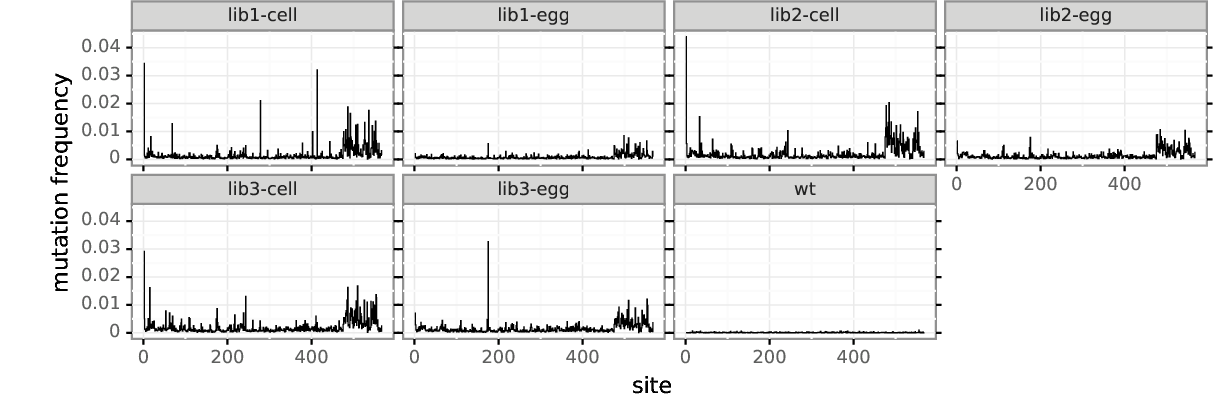

In [9]:
showPDF(countsplotprefix + '_mutfreq.pdf')

Sampling of mutations is fairly good in all cases. Often a bit more in cell because there is probably less selection against bad mutations there:

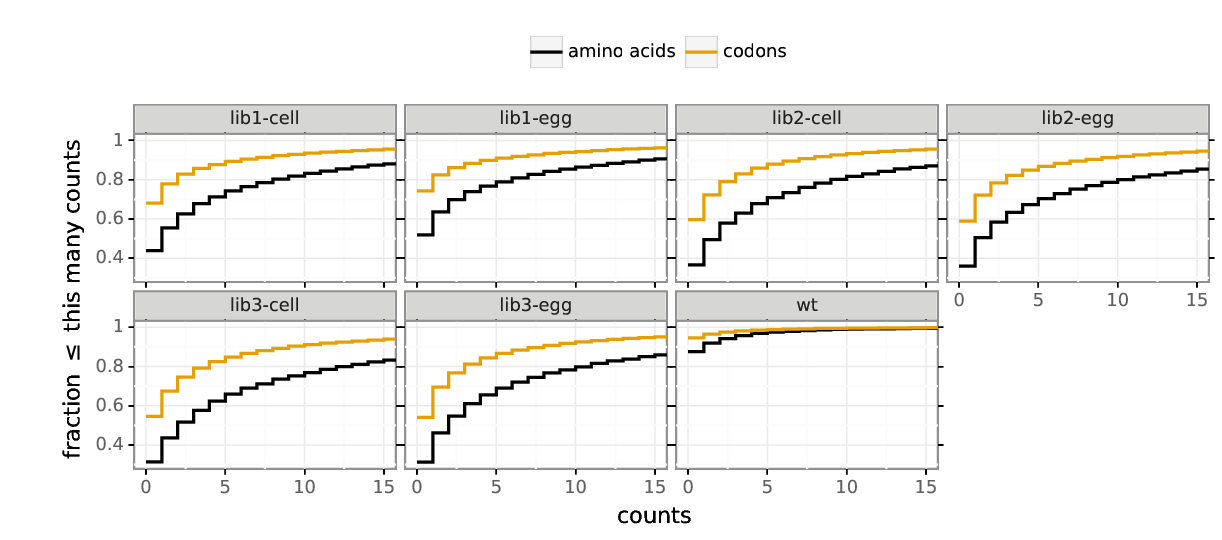

In [10]:
showPDF(countsplotprefix + '_cumulmutcounts.pdf')

We see stronger selection against stop / nonsynonymous mutations in eggs than in cells:

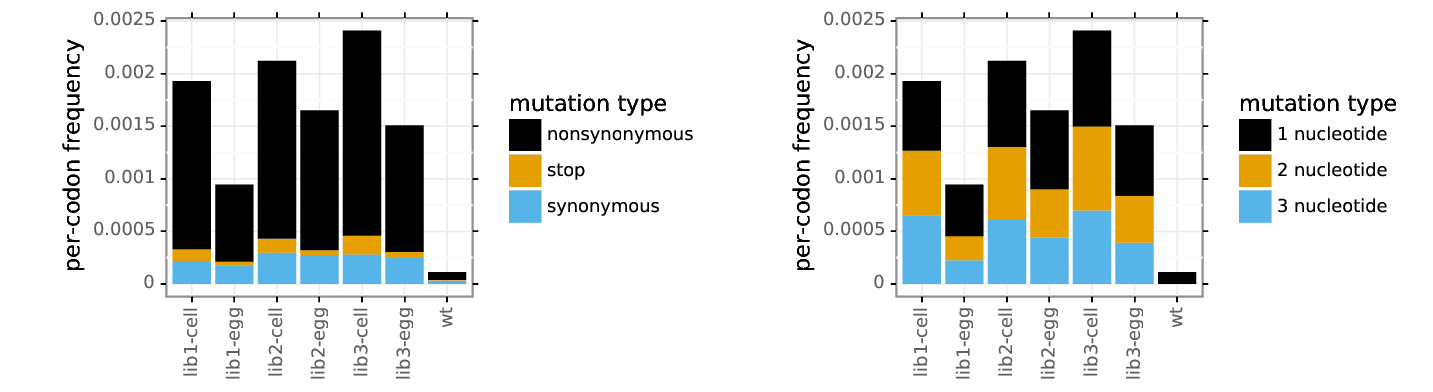

In [11]:
showPDF([countsplotprefix + '_codonmuttypes.pdf',
         countsplotprefix + '_codonntchanges.pdf'])

Is there oxidative damage? Indicated by an excess of `C->A` and `G->T`.
No indication of oxidative damage:

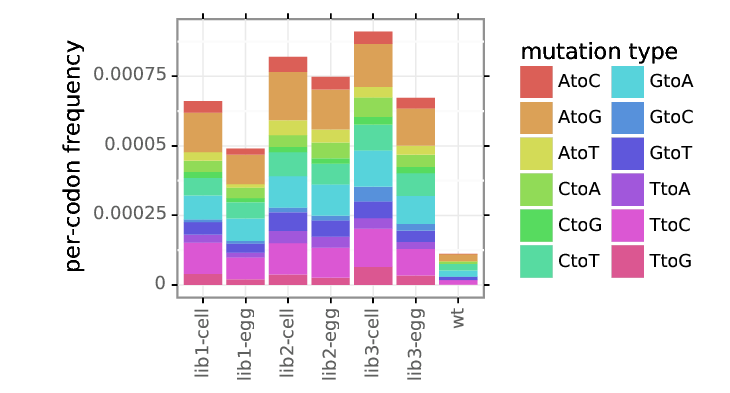

In [12]:
showPDF(countsplotprefix + '_singlentchanges.pdf')

## Renumber to H3 numbering
The above alignments use sequential 1, 2, ... numbering of the codons. This is not the standard numbering scheme used for HA, so we use dms_tools2.utils.renumbSites to renumber to the standard HA numbering scheme:

In [13]:
renumb_codoncounts = './results/renumbered_codoncounts/'

dms_tools2.utils.renumberSites(
    renumbfile='./data/H3renumbering_scheme.csv',
    infiles=samples['countsfile'].tolist(),
    missing='drop',
    outdir=renumb_codoncounts)

samples['renumb_countsfile'] = (renumb_codoncounts +
                                samples['countsfile'].map(os.path.basename)
                                )

assert all(map(os.path.isfile, samples['renumb_countsfile'])), 'missing renumbered counts files'

print(f"Renumbered codon counts are in {renumb_codoncounts}")

Renumbered codon counts are in ./results/renumbered_codoncounts/


## Compute differential selection in egg versus cell virus
We need to specify the "mock" (cell virus), "sel" (egg virus), and "err" (wildtype error control) for each library:

In [14]:
selections = (
    samples
    [['name', 'renumb_countsfile']]
    .assign(library=lambda x: x['name'].map(lambda s: s.split('-')[0]))
    .query('library.str.contains("lib")')
    .assign(sample=lambda x: x['name'].map(lambda s: 'sel' if 'egg' in s else 'mock'))
    .pivot_table(values='renumb_countsfile',
                 index='library',
                 columns='sample',
                 aggfunc='sum')
    .reset_index()
    .rename(columns={'library': 'name'})
    .assign(err=samples.set_index('name').at['wt', 'renumb_countsfile'])
    )

selections

sample,name,mock,sel,err
0,lib1,./results/renumbered_codoncounts/lib1-cell_cod...,./results/renumbered_codoncounts/lib1-egg_codo...,./results/renumbered_codoncounts/wt_codoncount...
1,lib2,./results/renumbered_codoncounts/lib2-cell_cod...,./results/renumbered_codoncounts/lib2-egg_codo...,./results/renumbered_codoncounts/wt_codoncount...
2,lib3,./results/renumbered_codoncounts/lib3-cell_cod...,./results/renumbered_codoncounts/lib3-egg_codo...,./results/renumbered_codoncounts/wt_codoncount...


Now we run `dms2_batch_diffsel` on the selections:

In [15]:
diffseldir = './results/diffsel/'
os.makedirs(diffseldir, exist_ok=True)

# write batch file used by program
batchfile = os.path.join(diffseldir, 'batch.csv')
selections.to_csv(batchfile, index=False)

print('Computing diffsel...')
out = subprocess.check_output([
        'dms2_batch_diffsel',
        '--summaryprefix', 'summary',
        '--batchfile', batchfile,
        '--outdir', diffseldir,
        '--use_existing', 'yes',
        '--ncpus', str(ncpus),
        ])
print('Done computing diffsel.')

Computing diffsel...
Done computing diffsel.


We have now created a bunch of plots with information on the selection.

First, we look to see how correlated the results are among libraries.
We'll look at the correlation among the site differential selection values.
We do this for just positive diffsel (favored in egg) and total diffsel (just differential selection in one condition versus another):


Correlation of positive site differential selection:


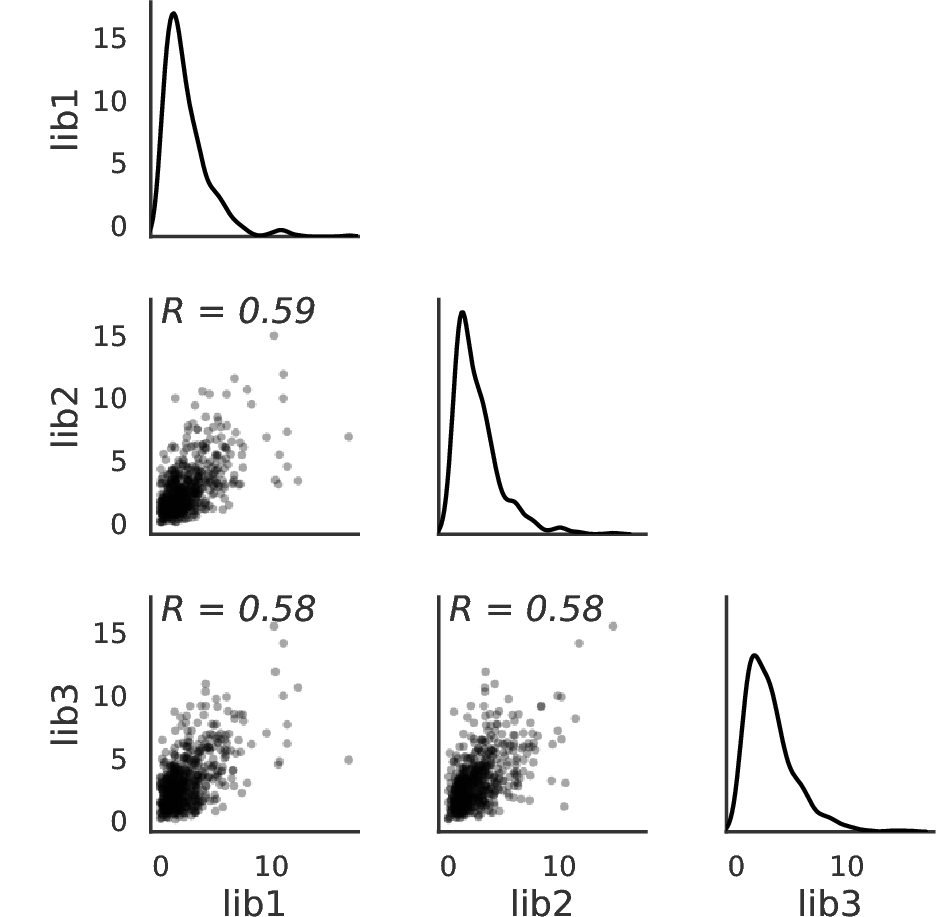


Correlation of absolute site differential selection:


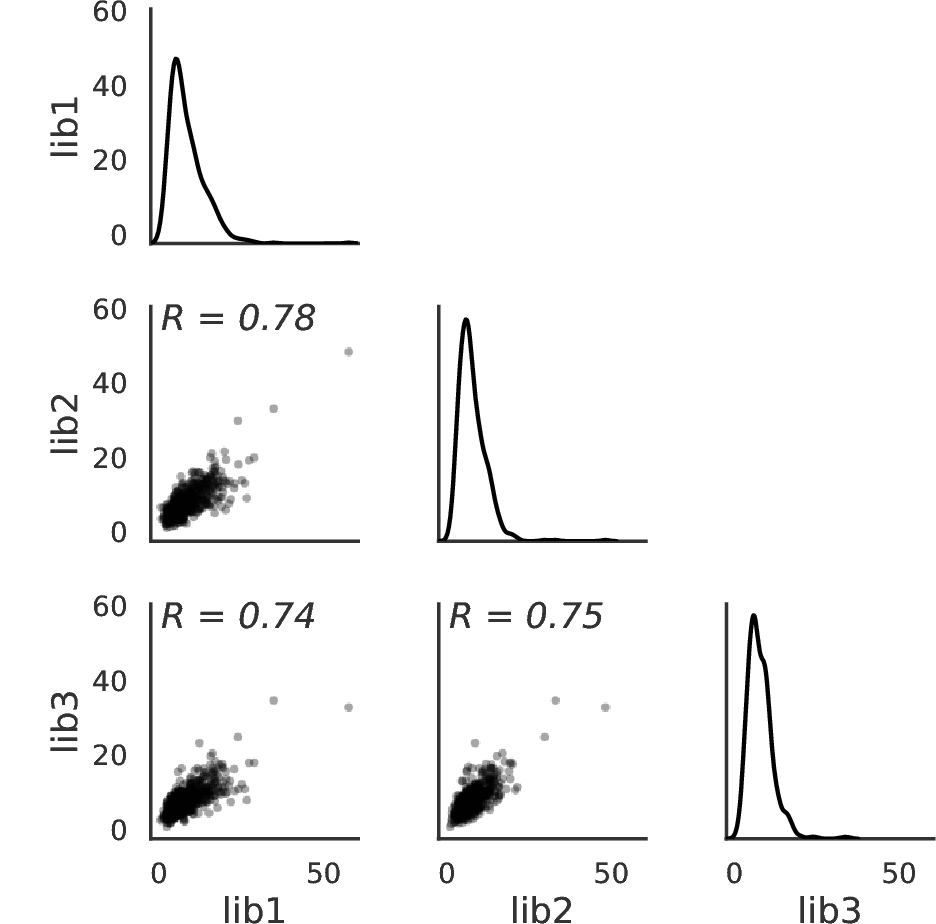

In [16]:
diffselprefix = os.path.join(diffseldir, 'summary_')

for seltype in ['positive', 'absolute']:
    print(f"\nCorrelation of {seltype} site differential selection:")
    showPDF(diffselprefix + f"{seltype}sitediffselcorr.pdf", width=400)

For everything below, we will look at the average (mean) of the three libraries.

Let's look at the selection across the length of the gene.
There is actually a lot more negative differential selection (sites disfavored in eggs relative to cells) than vice versa.
However, since the egg virus underwent another passage and was clearly more strongly selected, I think we should be cautious about interpreting this as it might just be more stringent selection against deleterious mutations:

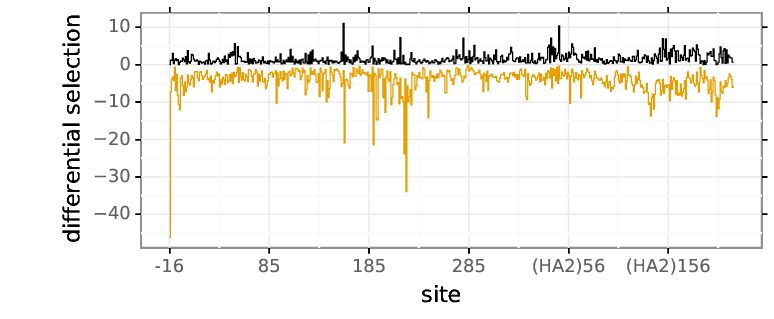

In [17]:
showPDF(diffselprefix + 'meantotaldiffsel.pdf')

Here we focus just on positive differential selection, which are sites where mutations are favored in the eggs over the cells:

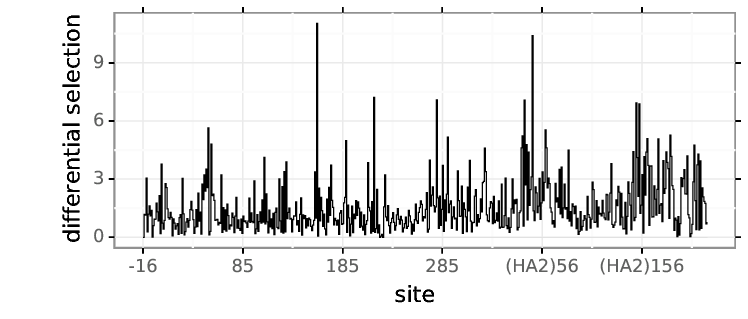

In [18]:
showPDF(diffselprefix + 'meanpositivediffsel.pdf')

## Plot differential selection across all of HA
We will now make a logo plot showing the mean positive differential selection across HA.
Taller letters indicate mutations that are more favored in egg versus cell:

Plotting differential selection in ./results/diffsel/summary_meanmutdiffsel.csv
Here is the logo plot in ./results/diffsel/egg-vs-cell_diffsel.pdf


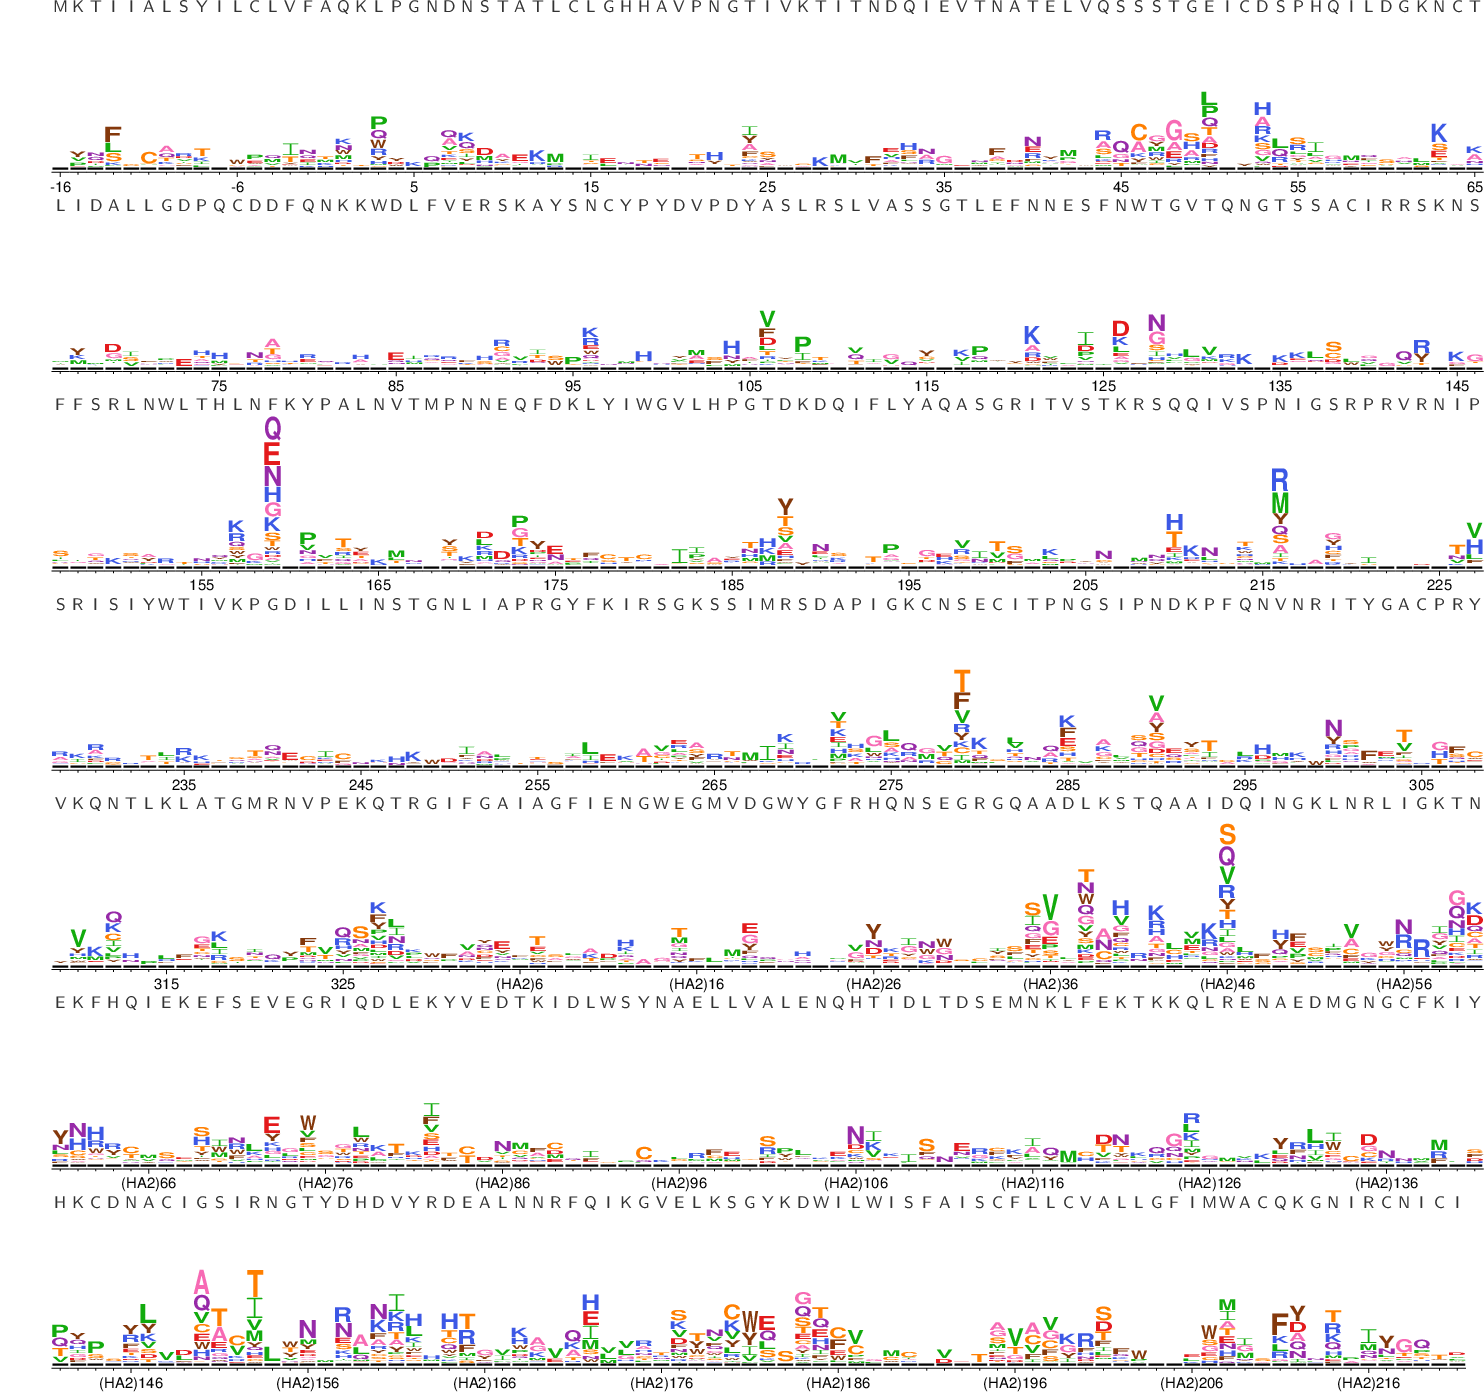

In [19]:
diffseldata = diffselprefix + 'meanmutdiffsel.csv'
print(f"Plotting differential selection in {diffseldata}")

out = subprocess.check_output([
        'dms2_logoplot',
        '--outdir', diffseldir,
        '--diffsel', diffseldata,
        '--restrictdiffsel', 'positive',
        '--nperline', '81',
        '--name', 'egg-vs-cell',
        '--overlay1', diffseldata, 'wildtype', 'wildtype',
        ])

logofile = os.path.join(diffseldir, 'egg-vs-cell_diffsel.pdf')

print(f"Here is the logo plot in {logofile}")
showPDF(logofile)

Some mutations (such as those at site 159) definitely are selected in eggs.
There also appears to be selection at other sites, although tt's hard for us to tell here what is signal and noise as the data are a bit noisy.
For instance, are the HA2 mutations really strongly selected or is that some unknown source of noise?

## Choose mutations for Hensley lab to test
The Hensley lab will test some of the mutations that are most favored in eggs versus cells.
Here we choose mutations to suggest for them.

First, add the names of the files with the differential selection for each library into our `selections` data frame:

In [20]:
selections = pd.concat(
    [selections
     .query('name != "average"')
     .assign(
        mutdiffsel_file=lambda x: diffseldir + x['name'] + '_mutdiffsel.csv',
        sitediffsel_file=lambda x: diffseldir + x['name'] + '_sitediffsel.csv',
        ),
     pd.DataFrame({'name': ['average'], 
                   'mutdiffsel_file': [diffseldir + 'summary_meanmutdiffsel.csv'],
                   'sitediffsel_file': [diffseldir + 'summary_meansitediffsel.csv']
                   })
     ],
     sort=False,
     ignore_index=True)

selections[['name', 'mutdiffsel_file', 'sitediffsel_file']]

,name,mutdiffsel_file,sitediffsel_file
0,lib1,./results/diffsel/lib1_mutdiffsel.csv,./results/diffsel/lib1_sitediffsel.csv
1,lib2,./results/diffsel/lib2_mutdiffsel.csv,./results/diffsel/lib2_sitediffsel.csv
2,lib3,./results/diffsel/lib3_mutdiffsel.csv,./results/diffsel/lib3_sitediffsel.csv
3,average,./results/diffsel/summary_meanmutdiffsel.csv,./results/diffsel/summary_meansitediffsel.csv


Now read all the diffsel values into a data frame:

In [21]:
diffsel = (dms_tools2.diffsel.df_read_filecols(
                    selections,
                    ['mutdiffsel_file', 'sitediffsel_file'])
           [['name', 'isite', 'site', 'wildtype', 'mutation',
             'mutdiffsel', 'positive_diffsel']]
           .rename(columns={'name': 'library'})
           .query('wildtype != mutation')
           )
diffsel.head()

,library,isite,site,wildtype,mutation,mutdiffsel,positive_diffsel
0,lib1,497,(HA2)153,R,T,7.037854,16.997482
1,lib1,497,(HA2)153,R,I,3.303171,16.997482
2,lib1,497,(HA2)153,R,Y,2.142533,16.997482
3,lib1,497,(HA2)153,R,P,1.274614,16.997482
4,lib1,497,(HA2)153,R,L,1.065005,16.997482


We want to choose specific strongly selected mutations.
However, we know from past experience that having a lot of selection at a site (for all mutations combined) is usually an indication that the mutation-level signal isn't just noise.

Therefore, we first identify the top most selected **sites**:

In [22]:
ntopsites = 30

topsites = (
 diffsel
 .query('library == "average"')
 .drop(columns=['mutation', 'mutdiffsel'])
 .drop_duplicates()
 .sort_values('positive_diffsel', ascending=False)
 .head(n=ntopsites)
 ['site']
 .tolist()
 )

print(f"The top {ntopsites} selected sites:\n{', '.join(topsites)}")

The top 30 selected sites:
159, (HA2)46, 216, 279, (HA2)38, (HA2)150, (HA2)153, 50, (HA2)59, (HA2)184, (HA2)36, 290, (HA2)161, (HA2)172, 188, 53, (HA2)40, (HA2)208, (HA2)60, (HA2)35, 327, (HA2)82, (HA2)147, (HA2)180, (HA2)42, (HA2)160, (HA2)212, (HA2)201, (HA2)185, (HA2)158


Now we get the top most selected mutations that are also at one of these top sites:

In [23]:
ntopmuts = 30

topmuts = (
 diffsel
 .query('library == "average"')
 .query('site in @topsites')
 .sort_values('mutdiffsel', ascending=False)
 .head(ntopmuts)
 [['isite', 'site', 'wildtype', 'mutation', 'library', 'mutdiffsel']]
 )

topmuts

,isite,site,wildtype,mutation,library,mutdiffsel
33960,497,(HA2)153,R,T,average,2.046161
33980,380,(HA2)36,A,V,average,1.965997
34000,494,(HA2)150,G,A,average,1.867718
34020,174,159,F,Q,average,1.862127
34021,174,159,F,E,average,1.745701
34040,231,216,N,R,average,1.734899
34060,294,279,S,T,average,1.705882
34140,390,(HA2)46,D,S,average,1.605799
34041,231,216,N,M,average,1.578012
33961,497,(HA2)153,R,I,average,1.562919


Now we want to get the selection for each of these mutations in the individual libraries.
Below we tabulate the selection for each library and the minimum across these libraries:

In [24]:
topmuts_by_lib = (
 diffsel
 .query('library != "average"')
 [['isite', 'site', 'wildtype', 'mutation', 'library', 'mutdiffsel']]
 .merge(topmuts,
        on=['isite', 'site', 'wildtype', 'mutation'],
        suffixes=['', '_average'])
 [['isite', 'mutation', 'library', 'mutdiffsel']]
 .pivot_table(index=['isite', 'mutation'],
              columns='library',
              values='mutdiffsel')
 .reset_index()
 .merge(topmuts)
 .rename(columns={'mutdiffsel': 'average'})
 [['isite', 'site', 'wildtype', 'mutation', 'average', 'lib1', 'lib2', 'lib3']]
 .sort_values('average', ascending=False)
 .assign(lib_min=lambda x: x[['lib1', 'lib2', 'lib3']].min(axis=1))
 .reset_index(drop=True)
 )

topmuts_by_lib

,isite,site,wildtype,mutation,average,lib1,lib2,lib3,lib_min
0,497,(HA2)153,R,T,2.046161,7.037854,-0.205749,-0.693622,-0.693622
1,380,(HA2)36,A,V,1.965997,2.144748,1.694741,2.058502,1.694741
2,494,(HA2)150,G,A,1.867718,2.811626,1.502360,1.289167,1.289167
3,174,159,F,Q,1.862127,3.358866,0.638319,1.589195,0.638319
4,174,159,F,E,1.745701,1.576078,1.680108,1.980916,1.576078
5,231,216,N,R,1.734899,3.856712,0.188108,1.159876,0.188108
6,294,279,S,T,1.705882,4.140831,0.621153,0.355663,0.355663
7,390,(HA2)46,D,S,1.605799,1.187484,0.669572,2.960342,0.669572
8,231,216,N,M,1.578012,1.679097,0.884681,2.170257,0.884681
9,497,(HA2)153,R,I,1.562919,3.303171,2.186624,-0.801039,-0.801039


We now filter to just mutations where the **minimum** selection for any library is $\ge 0.5$.
The rationale is that if it is "real" signal and not just noise, then there should be at least some selection for the mutation in every library.

In [25]:
topmuts_filtered = (
 topmuts_by_lib
 .query('lib_min >= 0.5')
 .reset_index(drop=True)
 )

topmuts_filtered

,isite,site,wildtype,mutation,average,lib1,lib2,lib3,lib_min
0,380,(HA2)36,A,V,1.965997,2.144748,1.694741,2.058502,1.694741
1,494,(HA2)150,G,A,1.867718,2.811626,1.502360,1.289167,1.289167
2,174,159,F,Q,1.862127,3.358866,0.638319,1.589195,0.638319
3,174,159,F,E,1.745701,1.576078,1.680108,1.980916,1.576078
4,390,(HA2)46,D,S,1.605799,1.187484,0.669572,2.960342,0.669572
5,231,216,N,M,1.578012,1.679097,0.884681,2.170257,0.884681
6,174,159,F,N,1.554732,1.622528,1.741981,1.299688,1.299688
7,390,(HA2)46,D,V,1.362040,1.431265,0.635758,2.019099,0.635758
8,294,279,S,F,1.299191,0.543442,1.472853,1.881277,0.543442
9,516,(HA2)172,Q,H,1.209308,1.851499,0.564073,1.212352,0.564073


The above table gives the mutations that we'd recommend as most likely to have the biggest effect. 
The *site* column is the number in H3-numbering, and the *isite* column is the number in sequential **0**, 1, 2, ... numbering.

If you only want to test some of them, they are ordered so that the ones we think are likely to be most favored in eggs are at the top of the list above.
Of course, you may want to do some hand curation of the list considering other factors too.
For isnstance, it may be less interesting to make many different mutations at the same site, or to make lots of mutations that we expect to alter antigenicity (like those at site 159).